# Selective Capacitated Fair Pickup and Delivery Problem

In [1]:
from dataclasses import dataclass
import math
from random import random

import matplotlib.pyplot as plt
import random
random.seed(1090)

## Defining an "Instance" class
we start by defining a "Instance" class that contains all the information we are given from an instance file. We can access the variables for each instance as attributes of our "Instance" class. This is the data strucutre our algorithms will act upon

In [2]:
@dataclass
class Instance:
    def __init__(self, filename: str | None = None):
        if filename is not None:
            self.load_from_file(filename)

    @staticmethod # tell python this method doesn't depend on "self"
    def read_tuple(f):
        return tuple(map(int, f.readline().split()))

    def load_from_file(self, filename):
        with open(filename) as input_file:
            params_line = input_file.readline().split(" ")
            self.n = int(params_line[0])
            self.n_k = int(params_line[1])
            self.C = int(params_line[2])
            self.gamma = int(params_line[3])
            self.rho = float(params_line[4])
            _ = input_file.readline()
            demand_line = [int(c_i) for c_i in input_file.readline().split()]
            _ = input_file.readline()
            self.depot = self.read_tuple(input_file)
            self.requests = []
            self.requests_location_array = []
            for i in range(self.n):
                pick_up = self.read_tuple(input_file)
                request = {
                    "pick_up": pick_up,
                    "drop_off": None,
                    "demand": demand_line[i],
                    "index": i
                }
                self.requests.append(request)
                self.requests_location_array.append(pick_up)
            for i in range(self.n):
                drop_off = self.read_tuple(input_file)
                self.requests[i]["drop_off"] = drop_off
                self.requests_location_array.append(drop_off)
            if input_file.readline().strip() != "":# make sure we are at the end of the file and there's no more content
                raise ValueError("Unexpected extra content at end of file")

In [3]:
# testing how the class works
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
aaa = Instance()
aaa.load_from_file(filename)
aaa.depot

(35, 35)

## Helper Functions for evaluating the performance of our algorithm

In [4]:
# takes two tuples representing carthesian coordinates as input
def a(u, v):
    return math.ceil(math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2))

# takes the route as list of indices of request locations as input
def get_total_distance(instance, route):
    total_distance = 0
    current_location = instance.depot # we start at the depot
    for location_index in route:
        location_index = location_index - 1 # be careful with off-by-one errors!
        next_location = instance.requests_location_array[location_index]
        total_distance = total_distance + a(current_location, next_location)
        current_location = next_location
    total_distance = total_distance + a(current_location, instance.depot)
    return total_distance

# take a list of routes as input
def get_Jain_fairness(instance, routes):
    numerator = 0
    denominator = 0
    for route in routes:
        d = get_total_distance(instance, route)
        numerator = numerator + d
        denominator = denominator + d**2
    return numerator**2 / (instance.n_k * denominator) # I know it says n in the assignment but n_k makes more sense and its like that on wikipedia

def objective_function(instance, routes):
    value = 0
    for route in routes:
        value = value + get_total_distance(instance, route)
    value = value + instance.rho * (1 - get_Jain_fairness(instance, routes))
    return value


From the assignment:

> A feasible solution consists of a route Rk for each vehicle k ∈ K, defined as an ordered sequence of
> pickup and drop-off locations with the i-th stop of a route being Rk,i. Each route must fulfill the
> following properties:
>
> • The vehicle capacity must never be exceeded at any point along the route.
>
> • Each served request must be handled in its entirety by a single vehicle.
>
> • At least γ requests must be served across all vehicles.

We create the following function to check this:

In [68]:
# does not work
def is_legal_route(instance, routes):
   pass


## Naive approach
Let's try a naive approach first to understand the problem format and to set a baseline we can compare against later. What's the simplest approach we can solve this problem with?
* every vehicle just drives from the depot to the resuest pick up location, then to the request drop off location, serve n/2 requests and then go back to the depot
* each vehicle serves n/n_k requests
* save route as list of int indices in an array

if index 1 is the pick up location, index 1 + n is the drop of location
So a naive route with n=10 & n_k = 2 would look like this

1 11 2 12 3 13 4 14 5 15

6 16 7 17 8 18 9 19 10 20

In [6]:
def naive_algorithm(instance):
    routes = []
    i = 1
    for k in range(instance.n_k):
        R_k = []
        request_to_serve = math.ceil(instance.n/instance.n_k)
        for request in range(request_to_serve):
            if i <= 2*instance.n:
                R_k.append(i)
                R_k.append(i + instance.n)
            else:
                print("Already all requests served")
            i = i + 1
        routes.append(R_k)
    return routes

In [7]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
routes = naive_algorithm(instance)

In [8]:
get_total_distance(instance, routes[0])

1840

In [9]:
get_Jain_fairness(instance, routes)

0.9997832046297458

In [10]:
objective_function(instance, routes)

3735.0056236719042

## Visualization
In order to get a better feeling what our algorithm is actually doing, here is a small visualization (Code generated with ChatGPT)

In [80]:
def plot_routes(instance, routes):
    plt.figure(figsize=(10, 10))
    plt.scatter(*instance.depot, c="black", marker="s", s=100, label="Depot")  # draw the depot

    # Draw each vehicle's route
    for i, route in enumerate(routes):
        color = f"C{i % 10}"  # use matplotlib color cycle
        x_coords = [instance.depot[0]]
        y_coords = [instance.depot[1]]

        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            x_coords.append(loc[0])
            y_coords.append(loc[1])

        x_coords.append(instance.depot[0])
        y_coords.append(instance.depot[1])

        plt.plot(x_coords, y_coords, "-", color=color, label=f"Vehicle {i+1}")

        # Mark pickups (▲) and drop-offs (▼)
        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            if idx <= instance.n:  # pickup
                plt.scatter(loc[0], loc[1], marker="^", color=color, s=70)
            else:  # drop-off
                plt.scatter(loc[0], loc[1], marker="v", color=color, s=70)

    # Compute metrics
    total_distance = sum(get_total_distance(instance, route) for route in routes)
    jain_score = get_Jain_fairness(instance, routes)
    obj_value = objective_function(instance, routes)

    # Add metrics to the plot
    plt.figtext(0.5, -0.01,  # x=0.5 centers it, y=-0.02 slightly below the plot
                f"Total Distance: {total_distance:.2f}    "
                f"Jain Fairness: {jain_score:.3f}    "
                f"Objective: {obj_value:.2f}",
                ha="center", fontsize=12)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.axis("equal")
    plt.show()

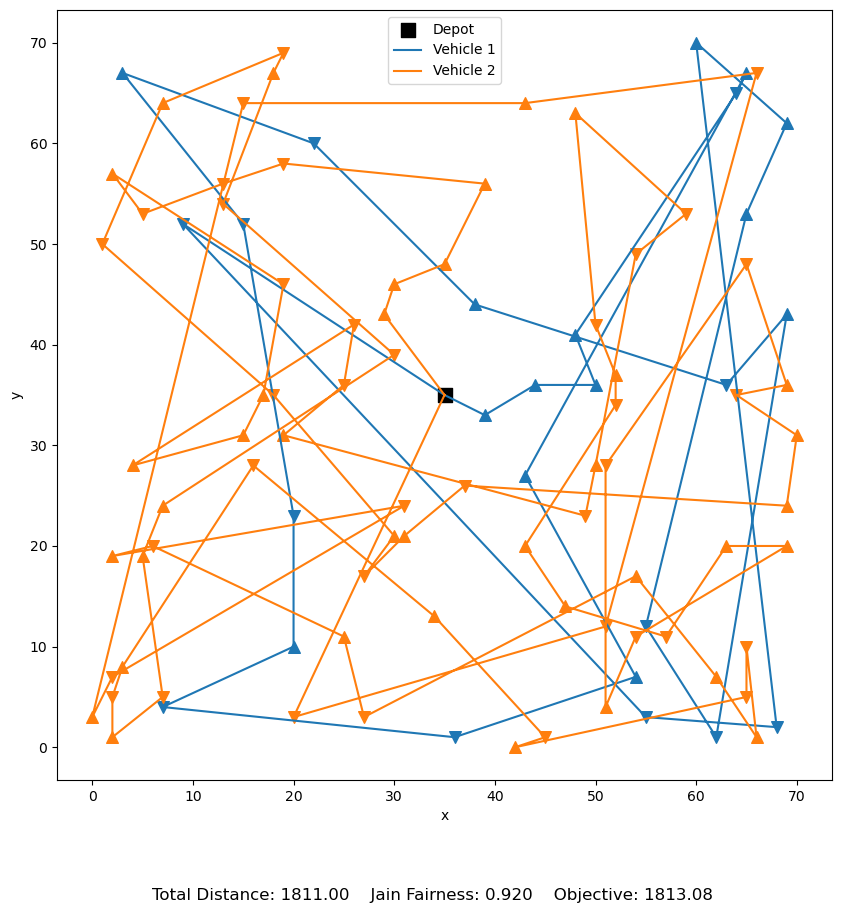

In [81]:
plot_routes(instance, routes)

## Subtask 1: Deterministic construction heuristic
For our first real subtask, we are asked to develop a meaningful construction heuristic. We chose to do so based on the Nearest Neighbor Heuristic, which means we start at an arbitrary node and always go to a nearest unvisited node. This seems like a reasonable choice.
We have to adapt this heuristic a little bit to match our specific problem, i.e. we have to take into account that we have multiple vehicles and we only need to satisfy gamma requests. So:
```
For each vehicle:
    - we look at the nearest pick up location
    - if we still have enough capacity, we go there and pick it up
    - if not, we go to the nearest drop of location
    - repeat until we have gamma requests done
```

<s>But apparently, this function still performs worse than the naive construction heuristic (in some cases)</s>

In [82]:
def nearest_neighbor_heuristic(instance):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]

    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            if not open_requests and not current_vehicle_requests[k]:
                continue
            print(f"lenopenreq: {len(open_requests)}")
            try:
                nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
            except ValueError: # we just don't have any open requests anyomore
                print("no more open requests")
            if len(open_requests) != 0 and (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C):
                print(f"PICKING UP: {nearest_pick_up_location}")
                print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            else:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [83]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
routes = nearest_neighbor_heuristic(instance)

lenopenreq: 50
PICKING UP: {'pick_up': (39, 33), 'drop_off': (7, 4), 'demand': 37, 'index': 4}
37
lenopenreq: 49
PICKING UP: {'pick_up': (29, 43), 'drop_off': (13, 56), 'demand': 18, 'index': 9}
18
lenopenreq: 48
PICKING UP: {'pick_up': (44, 36), 'drop_off': (36, 1), 'demand': 23, 'index': 16}
60
lenopenreq: 47
PICKING UP: {'pick_up': (30, 46), 'drop_off': (5, 53), 'demand': 21, 'index': 8}
39
lenopenreq: 46
PICKING UP: {'pick_up': (50, 36), 'drop_off': (64, 65), 'demand': 17, 'index': 29}
77
lenopenreq: 45
PICKING UP: {'pick_up': (35, 48), 'drop_off': (49, 23), 'demand': 20, 'index': 10}
59
lenopenreq: 44
PICKING UP: {'pick_up': (52, 37), 'drop_off': (52, 34), 'demand': 19, 'index': 17}
96
lenopenreq: 43
PICKING UP: {'pick_up': (38, 44), 'drop_off': (62, 1), 'demand': 25, 'index': 33}
84
lenopenreq: 42
DROPPING OFF: {'pick_up': (52, 37), 'drop_off': (52, 34), 'demand': 19, 'index': 17}
lenopenreq: 42
DROPPING OFF: {'pick_up': (35, 48), 'drop_off': (49, 23), 'demand': 20, 'index': 10}


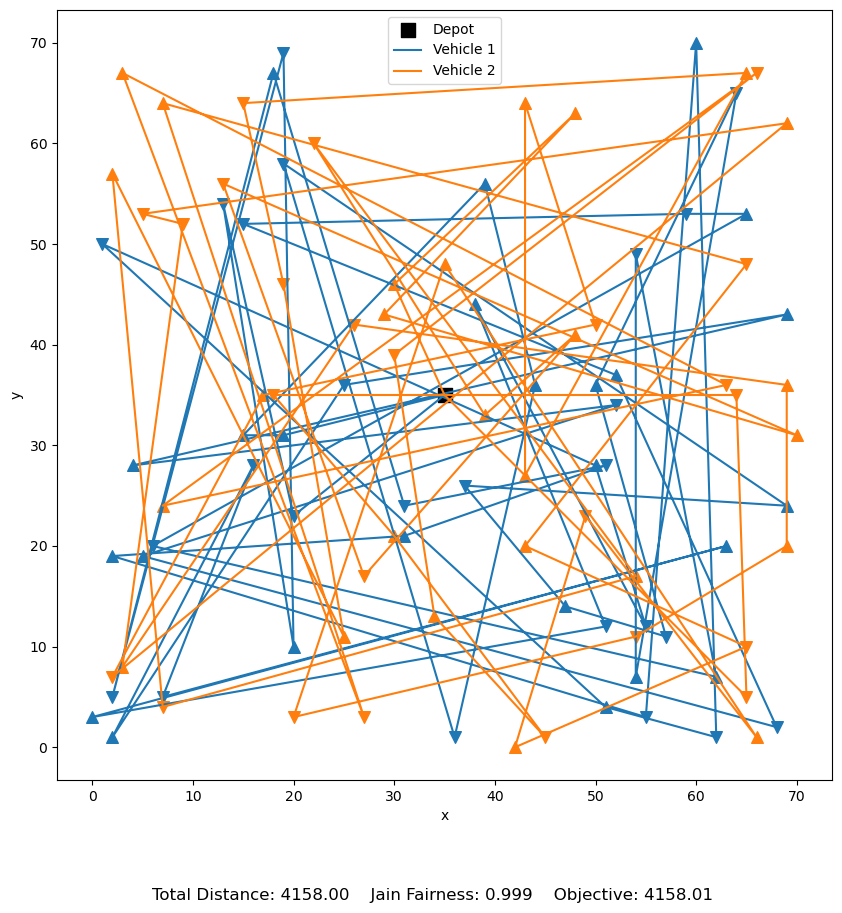

In [84]:
plot_routes(instance, routes)

In [85]:
get_total_distance(instance, routes[0])

2128

In [86]:
objective_function(instance,routes)

4158.014401640645

In [87]:
get_Jain_fairness(instance, routes)

0.9994448095356795

## Subtask 2: Deriving a randomized construction heuristic
to be applied iteratively, yielding diverse promising results. For that we are going to take our Nearest Neighbor Heuristic, but modify it so that the vehicles decide randomly to pick up (if they can) or drop of (if they can). We should probably include a parameter that controls the bias towards one or the other. This is the "bias" parameter:
* if it is set to 0, the vehicle will always try to pick up more stuff if possible
* if it is set to 1, the vehicle will always try to drop off more stuff if possible

In [88]:
def randomized_nearest_neighbor_heuristic(instance, bias):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]
    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            random_number = random.random()
            if not open_requests and not current_vehicle_requests[k]:
                continue
            #print(f"lenopenreq: {len(open_requests)}")
            try:
                nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
            except ValueError: # we just don't have any open requests anyomore
                pass
                #print("no more open requests")
            if ((bias <= random_number or (len(current_vehicle_requests[k]) == 0)) and
                    len(open_requests) != 0 and
                    (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C)):
                #print(f"PICKING UP: {nearest_pick_up_location}")
                #print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            else:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                #print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [89]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
routes = randomized_nearest_neighbor_heuristic(instance, 0.5)

In [90]:
objective_function(instance, routes)

4145.052689136625

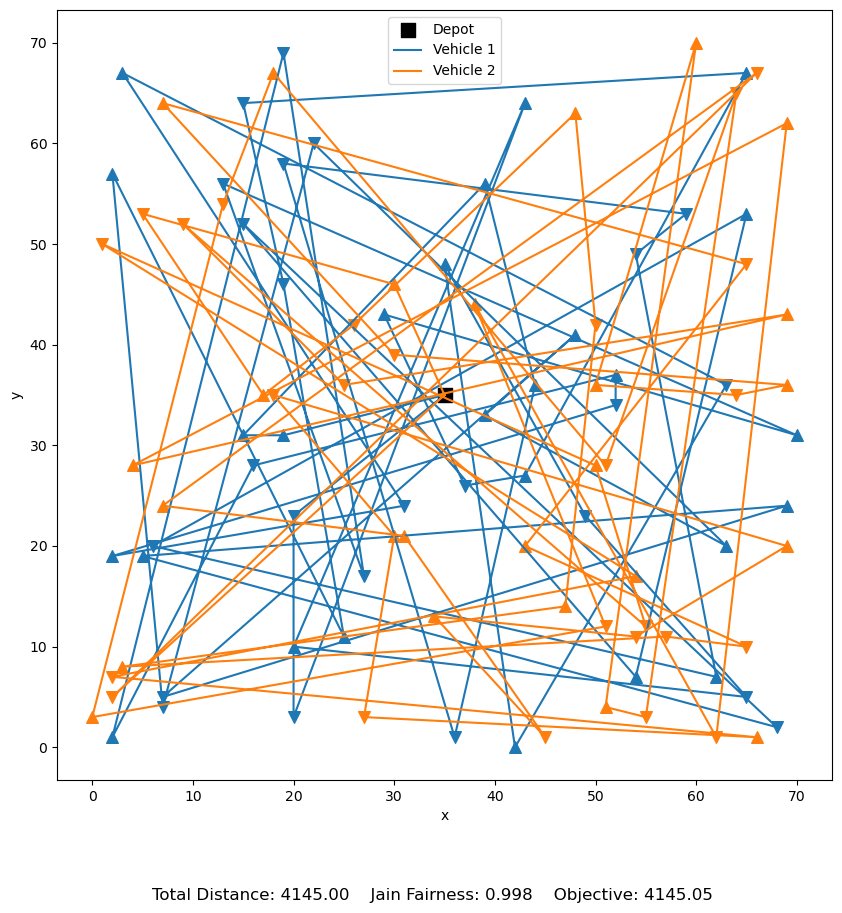

In [91]:
plot_routes(instance, routes)

## Subtask 3: Pilot / Beam Search

In this subtask, we are asked to develop either a Beam Search or a Pilot Search algorithm to hopefully improve our performance.
At first glance, Pilot Search appears attractive because it provides a more accurate evaluation of each decision by performing a complete greedy rollout for every candidate move:

| Aspect | **Beam Search** | **Pilot Search** |
|--------|------------------|------------------|
| **Core Idea** | Keep the β most promising partial solutions at each level | Evaluate each extension by completing it with a greedy rollout |
| **Evaluation Method** | Objective function on partial solutions | Full greedy completion from each extension |
| **Nodes Explored** | O(β·n) | O(n²) |
| **Computational Cost** | Lower (only evaluates partial solutions) | Higher (requires full greedy completion per extension) |
| **Look-Ahead** | Limited to the current level | Dynamic via simulated completions |
| **Accuracy** | Depends on objective quality | Generally higher (accounts for downstream effects) |

However, we encountered a structural issue in our previous algorithm design:
our heuristics optimized the vehicle routes in a round-robin fashion, meaning all vehicles were advanced simultaneously.
As a result, if the optimal behavior was something like
> “Vehicle 1 picks up request 5 and then immediately request 7 because it’s nearby,”
this was not possible — the algorithm would switch to vehicle 2 right after assigning a single request to vehicle 1.

To enable independent optimization of each vehicle’s route, we propose defining the node set as:

$$
(\text{set of all vehicles}) \times ((\text{open and feasible pickups}) \cup (\text{current requests for drop-off}))
$$

However, the nearest-neighbor heuristic we used earlier is not suitable for such independent vehicle optimization.
It also ignores the fairness objective, making it unreliable as a rollout policy for a Pilot Search.

**Therefore, we decided to implement a Beam Search approach**,
which evaluates partial global solutions directly and naturally supports both multi-vehicle coordination and the fairness objective.
In order to build the search tree, we also define a "State" class, that represents a node in this search tree. This class will also be useful for later algorithms.

In [92]:
# creating an own class to represent the nodes
@dataclass
class State:
    routes: list           # list[list[int]]
    loc: list              # current location per vehicle
    capacity: list              # current used capacity
    onboard: list          # onboard[k] = list of requests
    open_reqs: list        # list of remaining requests
    n_served: int
    score: float           # evaluation score

    def copy(self):
        """Create a deep copy of the state, but without copying the underlying request dicts."""
        return State(
            routes=[r.copy() for r in self.routes],
            loc=self.loc.copy(),
            capacity=self.capacity.copy(),
            onboard=[lst.copy() for lst in self.onboard],
            open_reqs=self.open_reqs.copy(),
            n_served=self.n_served,
            score=self.score
        )

In [93]:
# create the children nodes
def expand_state(instance, state):
    if state.open_reqs == [] and all(len(o)==0 for o in state.onboard):
        print("No possible moves in this state, served: ", state.n_served)
    successors = []
    for k in range(instance.n_k):
        # Pick up successors
        for req in state.open_reqs:
            if state.capacity[k] + req["demand"] <= instance.C:
                S2 = state.copy()
                old_loc = S2. loc[k] # move old vehicle
                new_loc = req["pick_up"]
                S2.loc[k] = new_loc
                S2.routes[k].append(req["index"])
                S2.onboard[k].append(req)
                S2.open_reqs.remove(req)
                S2.capacity[k] += req["demand"]
                S2.score  = objective_function(instance, S2.routes)
                successors.append(S2)
        # Drop off successors
        for req in state.onboard[k]:
            S2 = state.copy()
            old_loc = S2.loc[k]
            new_loc = req["drop_off"]
            S2.loc[k] = new_loc
            S2.routes[k].append(req["index"] + instance.n)
            S2.onboard[k].remove(req)
            S2.capacity[k] -= req["demand"]
            S2.score = objective_function(instance, S2.routes)
            S2.n_served += 1
            successors.append(S2)
    return successors

In [94]:
def beam_search(instance, beta):
    init = State(
        routes = [[] for _ in range(instance.n_k)],
        loc = [instance.depot for _ in range(instance.n_k)],
        capacity = [0 for _ in range(instance.n_k)],
        onboard=[[] for _ in range(instance.n_k)],
        open_reqs=instance.requests.copy(),
        n_served=0,
        score=0.0
    )
    beam = [init]
    while True:
        if all(s.n_served >= instance.gamma for s in beam):
            out = min(successors, key=lambda s: s.score)
            print(out)
            return out.routes
        successors = []
        for s in beam:
            successors.extend(expand_state(instance, s))

        successors.sort(key=lambda s: s.score)
        beam = successors[:beta]

In [95]:
routes = beam_search(instance, 100)
objective_function(instance, routes)

State(routes=[[5, 17, 30, 19, 80, 0, 50, 3, 67, 55, 36, 86, 53, 38, 69, 34, 88, 39, 84, 89, 15, 25, 27, 65, 77, 75], [10, 9, 11, 29, 79, 60, 59, 13, 63, 31, 16, 28, 81, 78, 4, 61, 35, 54, 66, 8, 58, 18, 68, 21, 12, 62, 2, 44, 94, 42, 92, 71, 22, 72, 33, 24, 74, 1, 83, 23, 73, 85, 32, 52, 26, 76, 82, 43, 14, 64, 7, 51, 37, 57, 45, 95, 46, 96, 87, 20, 6, 47, 70, 48, 56, 49, 99, 97, 41, 98, 40, 93, 91, 90]], loc=[(13, 54), (51, 12)], capacity=[0, 0], onboard=[[], []], open_reqs=[], n_served=50, score=1813.0821057021053)


1813.0821057021053

In [96]:
get_Jain_fairness(instance, routes)

0.9197337817229986

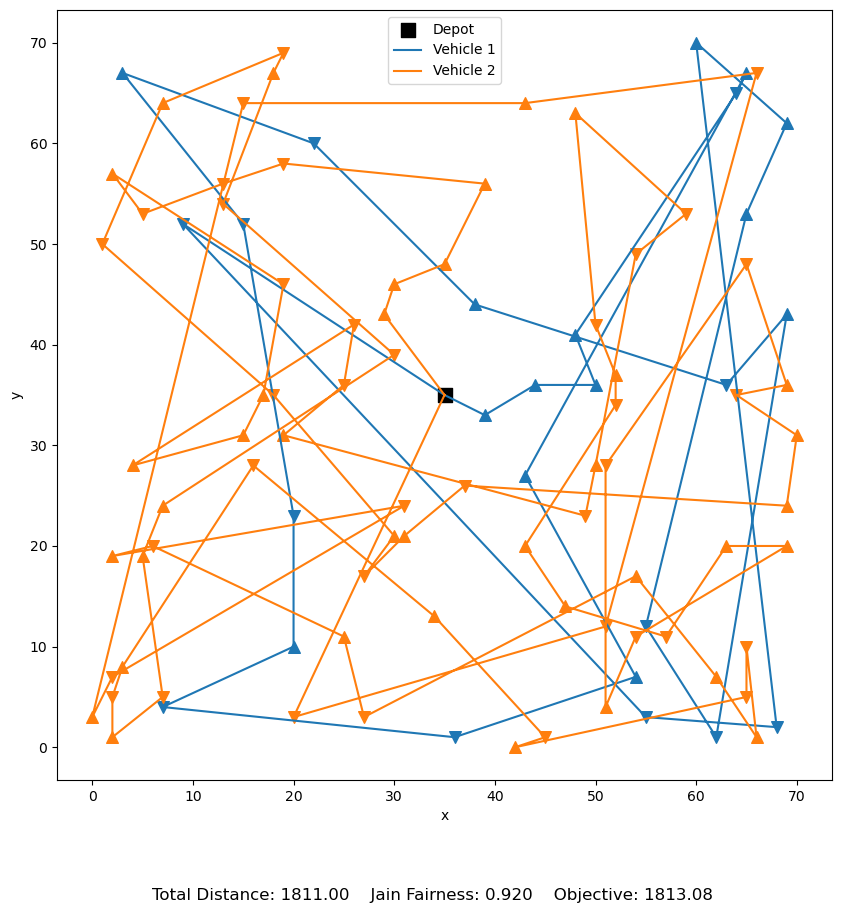

In [97]:
plot_routes(instance, routes)

## Subtask 4: Developing a framework for basic local search
which is able to deal with **different neighborhood structures** and different **step functions**
We descided to implement the following three neighborhood structures:
1.) A simple request relocation:
    We take a request from Veicle A and move it to vehicle B. Vehicle B drops the resuest of immedeatly after pick up
2.) flexible request relocation:
    We take a request from Veicle A and move it to vehicle B. We try to drop it off not immedeatly, but at a later, feasible time
3.) SwapNeighborhood:
    Swap a request of Vehicle A with a request of vehicle B.

Furthermore, we have to create a new State class, that only conists of the data we need.

In [107]:
@dataclass(frozen=True)
class State:
    routes: tuple[tuple[int]]
    served: frozenset
    unserved: frozenset
    score: float

    @staticmethod
    def from_routes(instance, routes):
        """Build State from raw routes (list of lists)."""
        served = set()
        for vroute in routes:
            for idx in vroute:
                if idx < instance.n:
                    served.add(idx)
        served = frozenset(served)
        unserved = frozenset(set(range(instance.n)) - served)
        score = objective_function(instance, routes)
        return State(
            routes=tuple(tuple(r) for r in routes),
            served=served,
            unserved=unserved,
            score=score
        )

In [99]:
# Some utility functions

def remove_request_from_route(route, req_idx, n):
    """Remove both pickup(req_idx) and dropoff(req_idx+n)."""
    new_route = [x for x in route if x != req_idx and x != req_idx+n]
    return new_route


def insert_request_compact(route, req_idx, n):
    """Insert pickup and then dropoff immediately after."""
    new_route = route.copy()
    # insert pickup at all possible positions
    for pos in range(len(route)+1):
        tmp = new_route[:pos] + [req_idx, req_idx + n] + new_route[pos:]
        yield tmp


def insert_request_flexible(route, req_idx, n):
    """Try all pickup and dropoff insertion positions (pickup_pos < dropoff_pos)."""
    L = len(route)
    for p in range(L+1):            # pickup position
        for d in range(p+1, L+2):   # dropoff position after pickup
            new_r = route[:p] + [req_idx] + route[p:d] + [req_idx+n] + route[d:]
            yield new_r


def capacity_feasible(instance, route):
    """Check capacity along route."""
    load = 0
    for idx in route:
        if idx < instance.n:    # pickup
            load += instance.requests[idx]["demand"]
            if load > instance.C:
                return False
        else:                   # dropoff
            real = idx - instance.n
            load -= instance.requests[real]["demand"]
            if load < 0:
                return False
    return True

In [100]:
class RelocateCompact:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue     # dropoff, skip
                req_idx = idx
                # Try removing from one vehicle, inserting in another
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_compact(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)



class RelocateFlexible:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue
                req_idx = idx
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_flexible(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)



class SwapRequests:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]

        # all pairs of vehicles
        for v1 in range(len(routes)):
            for v2 in range(v1+1, len(routes)):
                for idx1 in routes[v1]:
                    if idx1 >= self.n:
                        continue
                    for idx2 in routes[v2]:
                        if idx2 >= self.n:
                            continue

                        # remove both requests
                        r1_rem = remove_request_from_route(routes[v1], idx1, self.n)
                        r2_rem = remove_request_from_route(routes[v2], idx2, self.n)

                        # try inserting each into the other vehicle (compact insertion)
                        for r1_add in insert_request_compact(r1_rem, idx2, self.n):
                            for r2_add in insert_request_compact(r2_rem, idx1, self.n):
                                if capacity_feasible(self.instance, r1_add) and capacity_feasible(self.instance, r2_add):
                                    new_routes = []
                                    for k, r in enumerate(routes):
                                        if k == v1:
                                            new_routes.append(r1_add)
                                        elif k == v2:
                                            new_routes.append(r2_add)
                                        else:
                                            new_routes.append(r)
                                    yield State.from_routes(self.instance, new_routes)


In [101]:
def first_improvement(state, neighborhood):
    for neigh in neighborhood.neighbors(state):
        if neigh.score < state.score:
            return neigh
    return state

def best_improvement(state, neighborhood):
    best = state
    for neigh in neighborhood.neighbors(state):
        if neigh.score < best.score:
            best = neigh
    return best

## Subtask 5: Develop at least three different meaningful neighborhood structures
Since we have already done that in the previous part, we are going to skip this.

## Subtask 6: Variable Neighborhood descent
Develop or make use of a Variable Neighborhood Descent (VND) framework which uses your
neighborhood structures. This method is a local search metaheuristic that uses a list of neighborhood structures instead of a single one.
Method takes advantage of the following observations:

1. A local optimum with respect to one neighborhood structure
is not necessarily a local optimum with respect to another.

2. A global optimum is a local optimum with respect to all possible neighborhood
structures.
3.
3. For many problems good local optima are relatively close together.

In [110]:
def variable_neighborhood_descent(initial_state, neighborhoods, step_fn, max_iter=100):
    state = initial_state

    for it in range(max_iter):
        improved = False

        for N in neighborhoods:
            new_state = step_fn(state, N)
            if new_state.score < state.score:
                state = new_state
                #print("New Score: ", state.score)
                improved = True
                break

        if not improved:
            print(f"No more Improvements found after {it} iterations!")
            break

    return state

In [111]:
initial = State.from_routes(instance, routes)

# defining a list of neighborhoods
neighborhoods = [
    RelocateCompact(instance),
    RelocateFlexible(instance),
    SwapRequests(instance)
]

local_optimum = variable_neighborhood_descent(
    initial,
    neighborhoods,
    step_fn=first_improvement,
    max_iter=2000
)

print(local_optimum.score)

KeyboardInterrupt: 

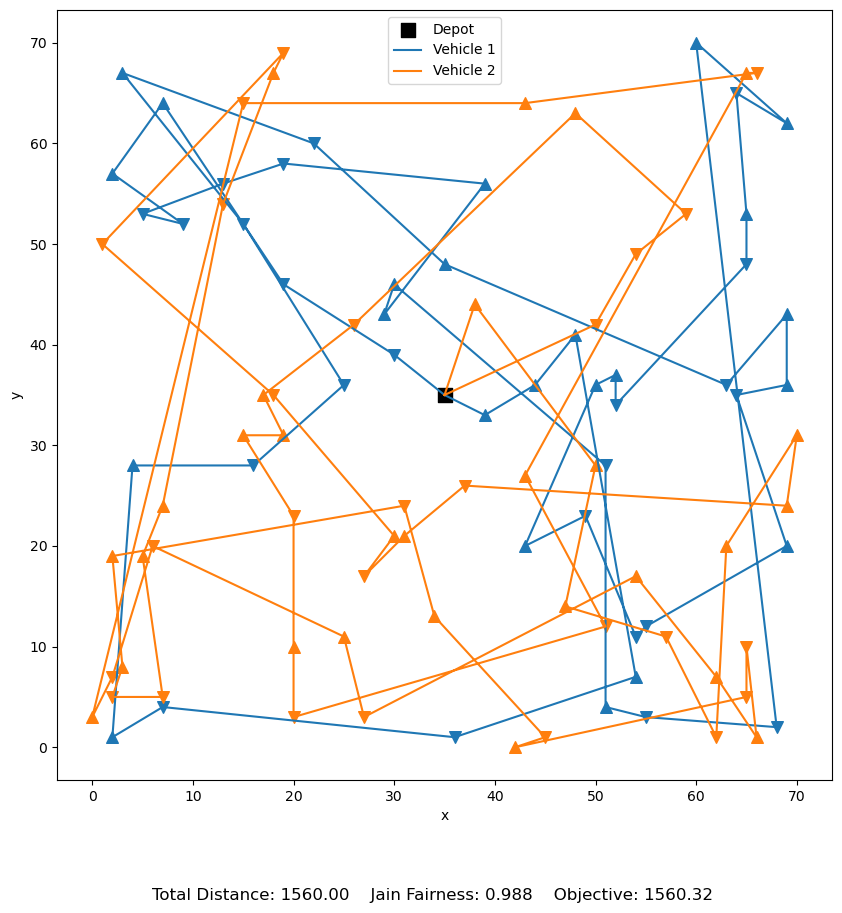

In [104]:
plot_routes(instance, local_optimum.routes)

## Subtask 7: GRASP (Greedy randomized Adaptive Search Procedure)
Now we are asked to implement GRASP using our randomized nearest neighbor construction heuristic from earlier, togehter with a step funciton
The algorithm works in two stages:

1.) greedy randomized construction

2.) Local search typically with best improvement

In [119]:
solutions = []
for i in range(10):
    random_bias = 1 - (0.1 * i)
    print(f"testing wiht bias {random_bias}")
    greedy_randomized = randomized_nearest_neighbor_heuristic(instance, random_bias)
    initial = State.from_routes(instance, greedy_randomized)
    neighborhoods = [
        RelocateCompact(instance),
        RelocateFlexible(instance),
        SwapRequests(instance)
    ]
    improvement = variable_neighborhood_descent(initial, neighborhoods, best_improvement, 200)
    solutions.append(improvement)
    print(f"Imrovement score: {improvement.score}")

best_solution = min(solutions, key=lambda s: s.score)

testing wiht bias 1.0
No more Improvements found after 58 iterations!
Imrovement score: 1702.263019797638
testing wiht bias 0.9
No more Improvements found after 76 iterations!
Imrovement score: 1518.2442536845056
testing wiht bias 0.8
No more Improvements found after 70 iterations!
Imrovement score: 1606.1083248676089
testing wiht bias 0.7
No more Improvements found after 77 iterations!
Imrovement score: 1463.0809337152155
testing wiht bias 0.6
No more Improvements found after 68 iterations!
Imrovement score: 1542.0035341669443
testing wiht bias 0.5
No more Improvements found after 64 iterations!
Imrovement score: 1510.6083332933595
testing wiht bias 0.3999999999999999
No more Improvements found after 64 iterations!
Imrovement score: 1608.8613211150778
testing wiht bias 0.29999999999999993
No more Improvements found after 79 iterations!
Imrovement score: 1542.6605203047586
testing wiht bias 0.19999999999999996
No more Improvements found after 74 iterations!
Imrovement score: 1558.33250

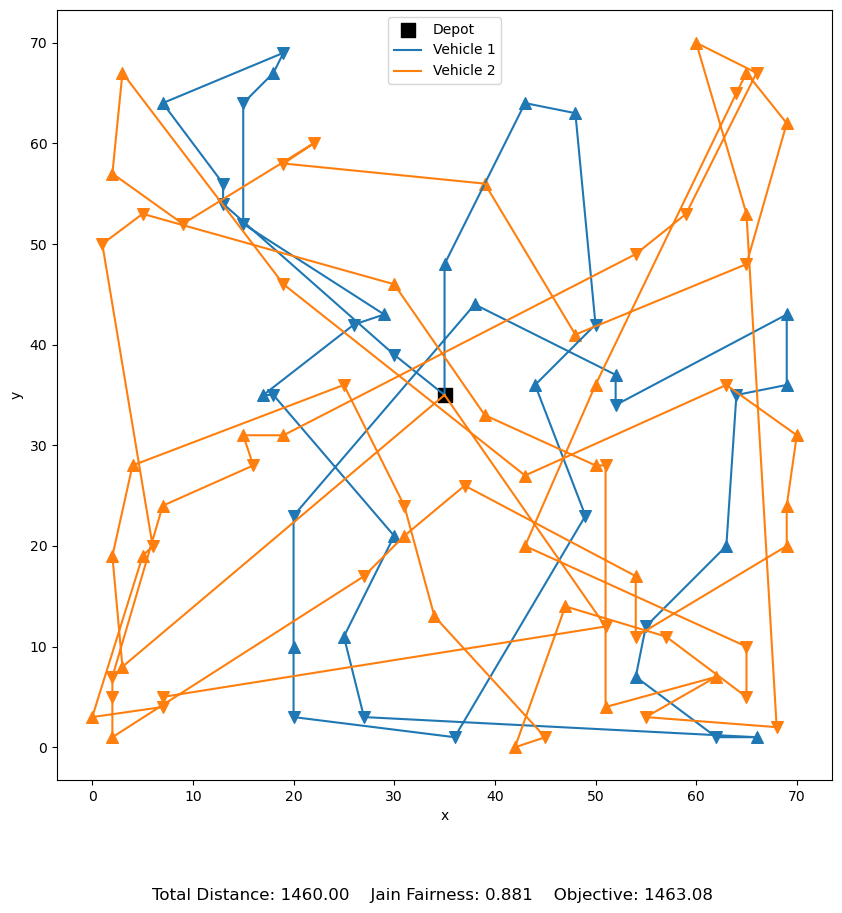

In [120]:
plot_routes(instance, best_solution.routes)